In [1]:
import pandas as pd
import sqlite3
import re
import string
import numpy as np
from sklearn.feature_extraction import stop_words
from collections import Counter
from wordcloud import WordCloud
import unicodedata
import os
import spacy
nlp = spacy.load("en_core_web_sm")

In [2]:
# this only needs to be run once
%load_ext rpy2.ipython

# load ggplot2
%R library(ggplot2)
%R library(scales)
%R library(ggwordcloud)
%R library(png)
%R library(grid)

array(['grid', 'png', 'ggwordcloud', 'scales', 'ggplot2', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'], dtype='<U11')

In [3]:
def words(text):
    """
    Given a string, return a list of words normalized as follows.
    Split the string to make words first by using regex compile() function
    and string.punctuation + '0-9\\r\\t\\n]' to replace all those
    char with a space character.
    Split on space to get word list.
    Ignore words < 3 char long.
    Lowercase all words
    Remove English stop words
    """

    text = text.lower()
    text = re.sub('[' + string.punctuation + '0-9\\r\\t\\n]', ' ', text)
    words = text.split(' ')
    words = [w for w in words if len(w) >= 3]  # ignore a, an, to, at, be, ...
    words = [w for w in words if w not in stop_words.ENGLISH_STOP_WORDS]

    return words

### Read Data

In [4]:
df_content = pd.read_csv(os.path.join('..','data','df_content.csv'))

### Create word count dfs

In [5]:
s_all_reviews = ''
for rev in df_content['content'].values:
    s_all_reviews += str(rev)

# remove weird x06 type stuff
new_str = unicodedata.normalize("NFKD", s_all_reviews)

# get list of words
w = words(new_str)

# get word count
word_counts = Counter(w)

In [6]:
# create word count df
df_word_counts = pd.DataFrame.from_dict(dict(word_counts), orient='index').reset_index()
df_word_counts.columns = ['word','count']

# filter df to show in wordcloud
df_wc_filt = df_word_counts.loc[df_word_counts['count']>3000].copy()
df_wc_filt.shape

(248, 2)

### Wordcloud of all words

In [7]:
%R -i df_wc_filt

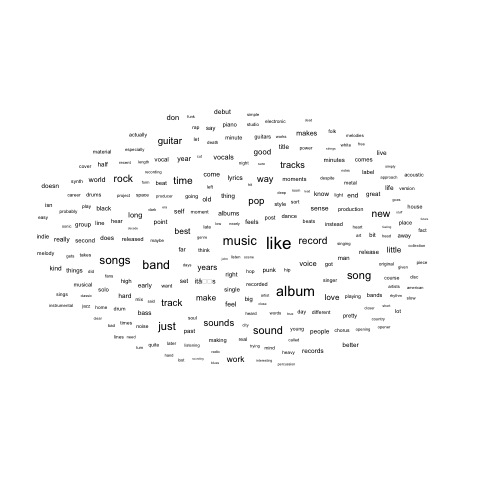

In [8]:
%%R

(ggplot()
+ geom_text_wordcloud(aes(label=word, size=count), df_wc_filt)
+ theme_void())

Not informative. Let's try adjectives.

### NLP Attempt

In [9]:
len(w)

6390240

In [10]:
len(set(w))

155500

In [11]:
s = ' '.join(set(w))

In [12]:
nlp.max_length = 1500000
doc = nlp(s)

In [13]:
winfo = []
for token in doc:
    winfo.append([token.text, token.pos_, token.is_stop])
    
df_nlp = pd.DataFrame(data=winfo, columns=['word','part of speech', 'stop word'])
df_nlp.head(2)

,word,part of speech,stop word
0,doeurve,VERB,False
1,freezingly,ADV,False


In [14]:
df_nlp['word_len'] = df_nlp['word'].str.len()
df_adj = df_nlp.loc[df_nlp['part of speech']=='ADJ'].drop_duplicates().reset_index(drop=True).copy()

In [15]:
df_adj_count = pd.merge(df_adj,
         df_word_counts,
         on='word')
df_adj_count.head(2)

,word,part of speech,stop word,word_len,count
0,exilo,ADJ,False,5,1
1,perpetual,ADJ,False,9,218


In [16]:
df_adj_count_filt = df_adj_count.loc[(df_adj_count['count']>500) & (df_adj_count['word_len']>5)]
df_adj_count_filt.shape

(340, 5)

In [42]:
df_obscure = df_adj_count.loc[(df_adj_count['count']>5) & (df_adj_count['word_len']>13)].sort_values(by='count',ascending=False)
df_obscure.shape

(137, 5)

In [43]:
ls_highlight = ['quintessential', 'transcendental', 'phosphorescent', 'deconstructive', 'extemporaneous']
df_obscure['highlight'] = 'no'
df_obscure.loc[df_obscure['word'].isin(ls_highlight),'highlight'] = 'yes'

In [44]:
df_obscure.loc[df_obscure['word'].str.startswith('dec')]

,word,part of speech,stop word,word_len,count,highlight
1227,deconstructive,ADJ,False,14,23,yes
12900,decontextualized,ADJ,False,16,9,no


In [45]:
df_obscure.head()

,word,part of speech,stop word,word_len,count,highlight
9376,straightforward,ADJ,False,15,1145,no
1506,aforementioned,ADJ,False,14,696,no
1898,instrumentalist,ADJ,False,15,379,no
12476,confrontational,ADJ,False,15,253,no
859,characteristic,ADJ,False,14,249,no


### Wordcloud of adjectives

In [46]:
%R -i df_adj_count_filt
%R -i df_obscure

In [ ]:
%%R  -w 10 -h 10 --units in -r 300 

set.seed(43)

wordcloud <- (ggplot()
+ geom_text_wordcloud(aes(label=word, size=count, color=highlight), 
                      df_obscure)
+ scale_colour_manual(values=c('black','dodgerblue2'))
+ theme_void())

print(wordcloud)